In [1]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, warnings, random, datetime, math

from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
########################### Helpers
#################################################################################
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
########################### Vars
#################################################################################
SEED = 42
seed_everything(SEED)
LOCAL_TEST = False
MAKE_MODEL_TEST = False
TARGET = 'isFraud'
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [4]:
########################### Model params
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':80000,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                } 

In [5]:
########################### Model
import lightgbm as lgb

def make_predictions(tr_df, tt_df, features_columns, target, lgb_params, NFOLDS=2):
    folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

    X,y = tr_df[features_columns], tr_df[target]    
    P,P_y = tt_df[features_columns], tt_df[target]  

    tt_df = tt_df[['TransactionID',target]]    
    predictions = np.zeros(len(tt_df))
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print('Fold:',fold_)
        tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
        vl_x, vl_y = X.iloc[val_idx,:], y[val_idx]
            
        print(len(tr_x),len(vl_x))
        tr_data = lgb.Dataset(tr_x, label=tr_y)

        if LOCAL_TEST:
            vl_data = lgb.Dataset(P, label=P_y) 
        else:
            vl_data = lgb.Dataset(vl_x, label=vl_y)  

        estimator = lgb.train(
            lgb_params,
            tr_data,
            valid_sets = [tr_data, vl_data],
            verbose_eval = 200,
        )   
        
        pp_p = estimator.predict(P)
        predictions += pp_p/NFOLDS

        if LOCAL_TEST:
            feature_imp = pd.DataFrame(sorted(zip(estimator.feature_importance(),X.columns)), columns=['Value','Feature'])
            print(feature_imp)
        
        del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
        gc.collect()
        
    tt_df['prediction'] = predictions
    
    return tt_df
## -------------------

def make_test_predictions(tr_df, tt_df, target, lgb_params, NFOLDS=2):
    
    new_columns = set(list(train_df)).difference(base_columns + remove_features)
    features_columns = base_columns + list(new_columns)
    
    folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

    X,y = tr_df[features_columns], tr_df[target]    
    P,P_y = tt_df[features_columns], tt_df[target]  

    for col in list(X):
        if X[col].dtype=='O':
            X[col] = X[col].fillna('unseen_before_label')
            P[col] = P[col].fillna('unseen_before_label')

            X[col] = train_df[col].astype(str)
            P[col] = test_df[col].astype(str)

            le = LabelEncoder()
            le.fit(list(X[col])+list(P[col]))
            X[col] = le.transform(X[col])
            P[col]  = le.transform(P[col])

            X[col] = X[col].astype('category')
            P[col] = P[col].astype('category')
        
    tt_df = tt_df[['TransactionID',target]]    
    predictions = np.zeros(len(tt_df))

    tr_data = lgb.Dataset(X, label=y)
    vl_data = lgb.Dataset(P, label=P_y) 
    estimator = lgb.train(
            lgb_params,
            tr_data,
            valid_sets = [tr_data, vl_data],
            verbose_eval = 200,
        )   
        
    pp_p = estimator.predict(P)
    predictions += pp_p/NFOLDS

    if LOCAL_TEST:
        feature_imp = pd.DataFrame(sorted(zip(estimator.feature_importance(),X.columns)), columns=['Value','Feature'])
        print(feature_imp)
        
    tt_df['prediction'] = predictions
    
    return tt_df
## -------------------

In [6]:
def values_normalization(dt_df, periods, columns):
    for period in periods:
        for col in columns:
            new_col = col +'_'+ period
            dt_df[col] = dt_df[col].astype(float)  

            temp_min = dt_df.groupby([period])[col].agg(['min']).reset_index()
            temp_min.index = temp_min[period].values
            temp_min = temp_min['min'].to_dict()

            temp_max = dt_df.groupby([period])[col].agg(['max']).reset_index()
            temp_max.index = temp_max[period].values
            temp_max = temp_max['max'].to_dict()

            temp_mean = dt_df.groupby([period])[col].agg(['mean']).reset_index()
            temp_mean.index = temp_mean[period].values
            temp_mean = temp_mean['mean'].to_dict()

            temp_std = dt_df.groupby([period])[col].agg(['std']).reset_index()
            temp_std.index = temp_std[period].values
            temp_std = temp_std['std'].to_dict()

            dt_df['temp_min'] = dt_df[period].map(temp_min)
            dt_df['temp_max'] = dt_df[period].map(temp_max)
            dt_df['temp_mean'] = dt_df[period].map(temp_mean)
            dt_df['temp_std'] = dt_df[period].map(temp_std)

            dt_df[new_col+'_min_max'] = (dt_df[col]-dt_df['temp_min'])/(dt_df['temp_max']-dt_df['temp_min'])
            dt_df[new_col+'_std_score'] = (dt_df[col]-dt_df['temp_mean'])/(dt_df['temp_std'])
            del dt_df['temp_min'],dt_df['temp_max'],dt_df['temp_mean'],dt_df['temp_std']
    return dt_df

In [7]:
def frequency_encoding(train_df, test_df, columns, self_encoding=False):
    for col in columns:
        temp_df = pd.concat([train_df[[col]], test_df[[col]]])
        fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
        if self_encoding:
            train_df[col] = train_df[col].map(fq_encode)
            test_df[col]  = test_df[col].map(fq_encode)            
        else:
            train_df[col+'_fq_enc'] = train_df[col].map(fq_encode)
            test_df[col+'_fq_enc']  = test_df[col].map(fq_encode)
    return train_df, test_df

In [8]:
def timeblock_frequency_encoding(train_df, test_df, periods, columns, 
                                 with_proportions=True, only_proportions=False):
    for period in periods:
        for col in columns:
            new_col = col +'_'+ period
            train_df[new_col] = train_df[col].astype(str)+'_'+train_df[period].astype(str)
            test_df[new_col]  = test_df[col].astype(str)+'_'+test_df[period].astype(str)

            temp_df = pd.concat([train_df[[new_col]], test_df[[new_col]]])
            fq_encode = temp_df[new_col].value_counts().to_dict()

            train_df[new_col] = train_df[new_col].map(fq_encode)
            test_df[new_col]  = test_df[new_col].map(fq_encode)
            
            if only_proportions:
                train_df[new_col] = train_df[new_col]/train_df[period+'_total']
                test_df[new_col]  = test_df[new_col]/test_df[period+'_total']

            if with_proportions:
                train_df[new_col+'_proportions'] = train_df[new_col]/train_df[period+'_total']
                test_df[new_col+'_proportions']  = test_df[new_col]/test_df[period+'_total']

    return train_df, test_df

In [9]:
def uid_aggregation(train_df, test_df, main_columns, uids, aggregations):
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col+'_'+main_column+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name]  = test_df[col].map(temp_df)
    return train_df, test_df

def uid_aggregation_and_normalization(train_df, test_df, main_columns, uids, aggregations):
    for main_column in main_columns:  
        for col in uids:
            
            new_norm_col_name = col+'_'+main_column+'_std_norm'
            norm_cols = []
            
            for agg_type in aggregations:
                new_col_name = col+'_'+main_column+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name]  = test_df[col].map(temp_df)
                norm_cols.append(new_col_name)
            
            train_df[new_norm_col_name] = (train_df[main_column]-train_df[norm_cols[0]])/train_df[norm_cols[1]]
            test_df[new_norm_col_name]  = (test_df[main_column]-test_df[norm_cols[0]])/test_df[norm_cols[1]]          
            
            del train_df[norm_cols[0]], train_df[norm_cols[1]]
            del test_df[norm_cols[0]], test_df[norm_cols[1]]
                                              
    return train_df, test_df


In [10]:
def check_cor_and_remove(train_df, test_df, i_cols, new_columns, remove=False):
    # Check correllation
    print('Correlations','#'*10)
    for col in new_columns:
        cor_cof = np.corrcoef(train_df[TARGET], train_df[col].fillna(0))[0][1]
        print(col, cor_cof)

    if remove:
        print('#'*10)
        print('Best options:')
        best_fe_columns = []
        for main_col in i_cols:
            best_option = ''
            best_cof = 0
            for col in new_columns:
                if main_col in col:
                    cor_cof = np.corrcoef(train_df[TARGET], train_df[col].fillna(0))[0][1]
                    cor_cof = (cor_cof**2)**0.5
                    if cor_cof>best_cof:
                        best_cof = cor_cof
                        best_option = col

            print(main_col, best_option, best_cof)            
            best_fe_columns.append(best_option)

        for col in new_columns:
            if col not in best_fe_columns:
                del train_df[col], test_df[col]

    return train_df, test_df

----

In [11]:
########################### DATA LOAD
#################################################################################
print('Load Data')
train_df = pd.read_csv('../input/train_transaction.csv')

if LOCAL_TEST:
    
    # Convert TransactionDT to "Month" time-period. 
    # We will also drop penultimate block 
    # to "simulate" test set values difference
    train_df['DT_M'] = train_df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    train_df['DT_M'] = (train_df['DT_M'].dt.year-2017)*12 + train_df['DT_M'].dt.month 
    test_df = train_df[train_df['DT_M']==train_df['DT_M'].max()].reset_index(drop=True)
    train_df = train_df[train_df['DT_M']<(train_df['DT_M'].max()-1)].reset_index(drop=True)
    
    train_identity = pd.read_csv('../input/train_identity.csv')
    test_identity  = train_identity[train_identity['TransactionID'].isin(
                                    test_df['TransactionID'])].reset_index(drop=True)
    train_identity = train_identity[train_identity['TransactionID'].isin(
                                    train_df['TransactionID'])].reset_index(drop=True)
    del train_df['DT_M'], test_df['DT_M']
    
else:
    test_df = pd.read_csv('../input/test_transaction.csv')
    train_identity = pd.read_csv('../input/train_identity.csv')
    test_identity = pd.read_csv('../input/test_identity.csv')
    
print('Shape control:', train_df.shape, test_df.shape)

Load Data
Shape control: (590540, 394) (506691, 393)


In [12]:
########################### All features columns
#################################################################################
## Main Data
# 'TransactionID',                     -> This is pure noise, we cannot use this column as feature
# 'isFraud',                           -> Our Target
# 'TransactionDT',                     -> Time from reference time point. VERY valuable column
# 'TransactionAmt',                    -> Many unique values and has to be combined with other columns
#                                         The best score boost should come from 
#                                         TransactionDT->TransactionAmt combination
# 'ProductCD',                         -> 100% categorical feature options to use:
#                                         Frequency encoding/Target encoding/
#                                         Combinations with other columns/Model categorical feature
# 'card1' - 'card6',                   -> Categorical features with information about Client
# 'addr1' - 'addr2',                   -> add2 - Country / addr1 - subzone
# 'dist1' - 'dist2',                   -> dist2 - Country distance / dist1 - local distance from merchant
# 'P_emaildomain' - 'R_emaildomain',   -> Categorical feature. It's possible to make 
#                                         subgroup feature from it or general group
# 'C1' - 'C14'                         -> Counts. Should be numerical features (all ints?)
# 'D1' - 'D15'                         -> Timedeltas - minimal value will be same for each month and day
#                                         but maximum and mean values will grow over time 
# 'M1' - 'M9'
# 'V1' - 'V339'

## Identity Data
# 'TransactionID'
# 'id_01' - 'id_38'
# 'DeviceType',
# 'DeviceInfo'

# Add list of feature that we will
# remove later from final features list
remove_features = [
    'TransactionID','TransactionDT', # These columns are pure noise right now
    TARGET,
    ]

base_columns = [col for col in list(train_df) if col not in remove_features]

In [13]:
#### Let's make baseline model 
if MAKE_MODEL_TEST:
    test_predictions = make_test_predictions(train_df, test_df, TARGET, lgb_params)
    print(metrics.roc_auc_score(test_predictions[TARGET], test_predictions['prediction']))
####

In [14]:
########################### TransactionDT
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
dates_range = pd.date_range(start='2017-10-01', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())

# Let's add temporary "time variables" for aggregations
# and add normal "time variables"
for df in [train_df, test_df]:
    
    # Temporary variables for aggregation
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = ((df['DT'].dt.year-2017)*12 + df['DT'].dt.month).astype(np.int8)
    df['DT_W'] = ((df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear).astype(np.int8)
    df['DT_D'] = ((df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear).astype(np.int16)
    
    df['DT_hour'] = (df['DT'].dt.hour).astype(np.int8)
    df['DT_day_week'] = (df['DT'].dt.dayofweek).astype(np.int8)
    df['DT_day_month'] = (df['DT'].dt.day).astype(np.int8)
        
    # Possible solo feature
    df['is_december'] = df['DT'].dt.month
    df['is_december'] = (df['is_december']==12).astype(np.int8)

    # Holidays
    df['is_holiday'] = (df['DT'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)

# Remove temporary features from final list
remove_features += ['DT','DT_M','DT_W','DT_D','DT_hour','DT_day_week','DT_day_month']
    
# Total transactions per timeblock
for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    train_df[col+'_total'] = train_df[col].map(fq_encode)
    test_df[col+'_total']  = test_df[col].map(fq_encode)
    
    # We can't use it as solo feature
    remove_features.append(col+'_total')

In [15]:
########################### Start with FE
# Before we start with FE I would like to do
# few things
# 1. Find and reset "outliers" for card1 and card2
# 2. Create "Virtual" client uID
# Reset values for "noise" card1

In [16]:
########################### Card columns "outliers"
for col in ['card1']: 
    valid_card = pd.concat([train_df[[col]], test_df[[col]]])
    valid_card = valid_card[col].value_counts()
    valid_card_std = valid_card.values.std()

    invalid_cards = valid_card[valid_card<=2]
    print('Rare cards',len(invalid_cards))

    valid_card = valid_card[valid_card>2]
    valid_card = list(valid_card.index)

    print('No intersection in Train', len(train_df[~train_df[col].isin(test_df[col])]))
    print('Intersection in Train', len(train_df[train_df[col].isin(test_df[col])]))
    
    train_df[col] = np.where(train_df[col].isin(test_df[col]), train_df[col], np.nan)
    test_df[col]  = np.where(test_df[col].isin(train_df[col]), test_df[col], np.nan)

    train_df[col] = np.where(train_df[col].isin(valid_card), train_df[col], np.nan)
    test_df[col]  = np.where(test_df[col].isin(valid_card), test_df[col], np.nan)
    print('#'*20)

for col in ['card2','card3','card4','card5','card6',]: 
    print('No intersection in Train', col, len(train_df[~train_df[col].isin(test_df[col])]))
    print('Intersection in Train', col, len(train_df[train_df[col].isin(test_df[col])]))
    
    train_df[col] = np.where(train_df[col].isin(test_df[col]), train_df[col], np.nan)
    test_df[col]  = np.where(test_df[col].isin(train_df[col]), test_df[col], np.nan)
    print('#'*20)

Rare cards 5993
No intersection in Train 10396
Intersection in Train 580144
####################
No intersection in Train card2 5012
Intersection in Train card2 585528
####################
No intersection in Train card3 47
Intersection in Train card3 590493
####################
No intersection in Train card4 0
Intersection in Train card4 590540
####################
No intersection in Train card5 7279
Intersection in Train card5 583261
####################
No intersection in Train card6 30
Intersection in Train card6 590510
####################


In [17]:
########################### Client Virtual ID
# Let's add some kind of client uID based on cardID and addr columns
# The value will be very specific for each client so we need to remove it
# from final features. But we can use it for aggregations.
train_df['uid'] = train_df['card1'].astype(str)+'_'+train_df['card2'].astype(str)
test_df['uid'] = test_df['card1'].astype(str)+'_'+test_df['card2'].astype(str)

train_df['uid2'] = train_df['uid'].astype(str)+'_'+train_df['card3'].astype(str)+'_'+train_df['card5'].astype(str)
test_df['uid2'] = test_df['uid'].astype(str)+'_'+test_df['card3'].astype(str)+'_'+test_df['card5'].astype(str)

train_df['uid3'] = train_df['uid2'].astype(str)+'_'+train_df['addr1'].astype(str)+'_'+train_df['addr2'].astype(str)
test_df['uid3'] = test_df['uid2'].astype(str)+'_'+test_df['addr1'].astype(str)+'_'+test_df['addr2'].astype(str)

train_df['uid4'] = train_df['uid3'].astype(str)+'_'+train_df['P_emaildomain'].astype(str)
test_df['uid4'] = test_df['uid3'].astype(str)+'_'+test_df['P_emaildomain'].astype(str)

train_df['uid5'] = train_df['uid3'].astype(str)+'_'+train_df['R_emaildomain'].astype(str)
test_df['uid5'] = test_df['uid3'].astype(str)+'_'+test_df['R_emaildomain'].astype(str)

# Add values remove list
new_columns = ['uid','uid2','uid3','uid4','uid5']
remove_features += new_columns

print('#'*10)
print('Most common uIds:')
for col in new_columns:
    print('#'*10, col)
    print(train_df[col].value_counts()[:10])

# Do Global frequency encoding 
i_cols = ['card1','card2','card3','card5'] + new_columns
train_df, test_df = frequency_encoding(train_df, test_df, i_cols, self_encoding=False)

##########
Most common uIds:
########## uid
7919.0_194.0     14891
9500.0_321.0     14112
15885.0_545.0    10332
17188.0_321.0    10312
15066.0_170.0     7918
12695.0_490.0     7079
6019.0_583.0      6766
12544.0_321.0     6760
2803.0_100.0      6126
7585.0_553.0      5325
Name: uid, dtype: int64
########## uid2
9500.0_321.0_150.0_226.0     14112
15885.0_545.0_185.0_138.0    10332
17188.0_321.0_150.0_226.0    10312
7919.0_194.0_150.0_166.0      8844
15066.0_170.0_150.0_102.0     7918
12695.0_490.0_150.0_226.0     7079
6019.0_583.0_150.0_226.0      6766
12544.0_321.0_150.0_226.0     6760
2803.0_100.0_150.0_226.0      6126
7919.0_194.0_150.0_nan        6047
Name: uid2, dtype: int64
########## uid3
15885.0_545.0_185.0_138.0_nan_nan       9900
17188.0_321.0_150.0_226.0_299.0_87.0    5862
12695.0_490.0_150.0_226.0_325.0_87.0    5766
9500.0_321.0_150.0_226.0_204.0_87.0     4647
3154.0_408.0_185.0_224.0_nan_nan        4398
12839.0_321.0_150.0_226.0_264.0_87.0    3538
16132.0_111.0_150.0_226.0

In [18]:
########################### card3/card5 most common hour 
# card3 or card5 is a bank country?
# can we find:
# - the most popular Transaction Hour
# - the most popular Week Day
# and then find distance from it

# Prepare bank type feature
for df in [train_df, test_df]:
    df['bank_type'] = df['card3'].astype(str) +'_'+ df['card5'].astype(str)
remove_features.append('bank_type') 

encoding_mean = {
    1: ['DT_D','DT_hour','_hour_dist','DT_hour_mean'],
    2: ['DT_W','DT_day_week','_week_day_dist','DT_day_week_mean'],
    3: ['DT_M','DT_day_month','_month_day_dist','DT_day_month_mean'],
    }

encoding_best = {
    1: ['DT_D','DT_hour','_hour_dist_best','DT_hour_best'],
    2: ['DT_W','DT_day_week','_week_day_dist_best','DT_day_week_best'],
    3: ['DT_M','DT_day_month','_month_day_dist_best','DT_day_month_best'],   
    }

# Some ugly code here (even worse than in other parts)
for col in ['card3','card5','bank_type']:
    for df in [train_df, test_df]:
        for encode in encoding_mean:
            encode = encoding_mean[encode].copy()
            new_col = col + '_' + encode[0] + encode[2]
            df[new_col] = df[col].astype(str) +'_'+ df[encode[0]].astype(str)

            temp_dict = df.groupby([new_col])[encode[1]].agg(['mean']).reset_index().rename(
                                                                    columns={'mean': encode[3]})
            temp_dict.index = temp_dict[new_col].values
            temp_dict = temp_dict[encode[3]].to_dict()
            df[new_col] = df[encode[1]] - df[new_col].map(temp_dict)

        for encode in encoding_best:
            encode = encoding_best[encode].copy()
            new_col = col + '_' + encode[0] + encode[2]
            df[new_col] = df[col].astype(str) +'_'+ df[encode[0]].astype(str)
            temp_dict = df.groupby([col,encode[0],encode[1]])[encode[1]].agg(['count']).reset_index().rename(
                                                                    columns={'count': encode[3]})

            temp_dict.sort_values(by=[col,encode[0],encode[3]], inplace=True)
            temp_dict = temp_dict.drop_duplicates(subset=[col,encode[0]], keep='last')
            temp_dict[new_col] = temp_dict[col].astype(str) +'_'+ temp_dict[encode[0]].astype(str)
            temp_dict.index = temp_dict[new_col].values
            temp_dict = temp_dict[encode[1]].to_dict()
            df[new_col] = df[encode[1]] - df[new_col].map(temp_dict)

In [19]:
#### Test new features
if MAKE_MODEL_TEST:
    test_predictions = make_test_predictions(train_df, test_df, TARGET, lgb_params)
    print(metrics.roc_auc_score(test_predictions[TARGET], test_predictions['prediction']))
####

In [20]:
########################### bank_type
# Tracking nomal activity
# by doing timeblock frequency encoding
i_cols = ['bank_type'] #['uid','uid2','uid3','uid4','uid5','bank_type']
periods = ['DT_M','DT_W','DT_D']

# We have few options to encode it here:
# - Just count transactions
# (but some timblocks have more transactions than others)
# - Devide to total transactions per timeblock (proportions)
# - Use both
# - Use only proportions
train_df, test_df = timeblock_frequency_encoding(train_df, test_df, periods, i_cols, 
                                 with_proportions=False, only_proportions=True)

In [ ]:
#### Test new features
if MAKE_MODEL_TEST:
    test_predictions = make_test_predictions(train_df, test_df, TARGET, lgb_params)
    print(metrics.roc_auc_score(test_predictions[TARGET], test_predictions['prediction']))
####

In [ ]:
########################### D Columns
i_cols = ['D'+str(i) for i in range(1,16)]
periods = ['DT_D']

temp_df = pd.concat([train_df[['TransactionDT']+i_cols+periods], test_df[['TransactionDT']+i_cols+periods]])
for period in periods:
    for col in i_cols:
        for df in [temp_df]:
            df.set_index(period)[col].plot(style='.', title=col, figsize=(15, 3))
            plt.show()

In [21]:
########################### D Columns
# From columns description we know that
# D1-D15: timedelta, such as days between previous transaction, etc.
# 1. I can't imagine normal negative timedelta values (Let's clip Values)
# 2. Normalize (Min-Max, Standard score) All D columns, except D1,D2,D9
# 3. Do some aggregations based on uIDs
# 4. Freaquency encoding
# 5. D1,D2 are clipped by max train_df values (let's scale it)
i_cols = ['D'+str(i) for i in range(1,16)]
uids = ['uid','uid2','uid3','uid4','uid5','bank_type']
aggregations = ['mean','std']

####### uIDs aggregations
train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

####### Cleaning Neagtive values and columns transformations
for df in [train_df, test_df]:

    for col in i_cols:
        df[col] = df[col].clip(0) 
    
    # Lets transform D8 and D9 column
    # As we almost sure it has connection with hours
    df['D9_not_na'] = np.where(df['D9'].isna(),0,1)
    df['D8_not_same_day'] = np.where(df['D8']>=1,1,0)
    df['D8_D9_decimal_dist'] = df['D8'].fillna(0)-df['D8'].fillna(0).astype(int)
    df['D8_D9_decimal_dist'] = ((df['D8_D9_decimal_dist']-df['D9'])**2)**0.5
    df['D8'] = df['D8'].fillna(-1).astype(int)

####### Values Normalization
i_cols.remove('D1')
i_cols.remove('D2')
i_cols.remove('D9')
periods = ['DT_D','DT_W','DT_M']
for df in [train_df, test_df]:
    df = values_normalization(df, periods, i_cols)

for col in ['D1','D2']:
    for df in [train_df, test_df]:
        df[col+'_scaled'] = df[col]/train_df[col].max()
        
####### Global Self frequency encoding
# self_encoding=True because 
# we don't need original values anymore
i_cols = ['D'+str(i) for i in range(1,16)]
train_df, test_df = frequency_encoding(train_df, test_df, i_cols, self_encoding=True)

In [ ]:
#### Test new features
if MAKE_MODEL_TEST:
    test_predictions = make_test_predictions(train_df, test_df, TARGET, lgb_params)
    print(metrics.roc_auc_score(test_predictions[TARGET], test_predictions['prediction']))
####

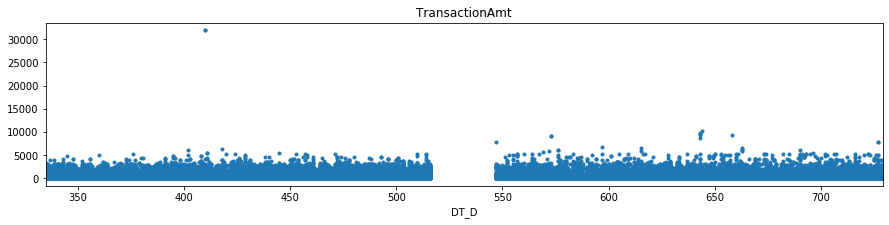

In [22]:
########################### TransactionAmt
i_cols = ['TransactionAmt']
periods = ['DT_D']

temp_df = pd.concat([train_df[['TransactionDT']+i_cols+periods], test_df[['TransactionDT']+i_cols+periods]])
for period in periods:
    for col in i_cols:
        for df in [temp_df]:
            df.set_index(period)[col].plot(style='.', title=col, figsize=(15, 3))
            plt.show()

# Clip Values
train_df['TransactionAmt'] = train_df['TransactionAmt'].clip(0,5000)
test_df['TransactionAmt']  = test_df['TransactionAmt'].clip(0,5000)

# Check if the Transaction Amount is common or not (we can use freq encoding here)
# In our dialog with a model we are telling to trust or not to these values   
train_df['TransactionAmt_check'] = np.where(train_df['TransactionAmt'].isin(test_df['TransactionAmt']), 1, 0)
test_df['TransactionAmt_check']  = np.where(test_df['TransactionAmt'].isin(train_df['TransactionAmt']), 1, 0)

# For our model current TransactionAmt is a noise
# https://www.kaggle.com/kyakovlev/ieee-check-noise
# (even if features importances are telling contrariwise)
# There are many unique values and model doesn't generalize well
# Lets do some aggregations
i_cols = ['TransactionAmt']
uids = ['card1','card2','card3','card5','uid','uid2','uid3','uid4','uid5','bank_type']
aggregations = ['mean','std']

# uIDs aggregations
train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)
 
# TransactionAmt Normalization
periods = ['DT_D','DT_W','DT_M']
for df in [train_df, test_df]:
    df = values_normalization(df, periods, i_cols)

# Product type
train_df['product_type'] = train_df['ProductCD'].astype(str)+'_'+train_df['TransactionAmt'].astype(str)
test_df['product_type'] = test_df['ProductCD'].astype(str)+'_'+test_df['TransactionAmt'].astype(str)

i_cols = ['product_type']
periods = ['DT_D','DT_W','DT_M']
train_df, test_df = timeblock_frequency_encoding(train_df, test_df, periods, i_cols, 
                                                 with_proportions=False, only_proportions=True)
train_df, test_df = frequency_encoding(train_df, test_df, i_cols, self_encoding=True)

# Small "hack" to transform distribution 
# (doesn't affect auc much, but I like it more)
# please see how distribution transformation can boost your score 
# (not our case but related)
# https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html
train_df['TransactionAmt'] = np.log1p(train_df['TransactionAmt'])
test_df['TransactionAmt'] = np.log1p(test_df['TransactionAmt'])

In [ ]:
#### Test new features
if MAKE_MODEL_TEST:
    test_predictions = make_test_predictions(train_df, test_df, TARGET, lgb_params)
    print(metrics.roc_auc_score(test_predictions[TARGET], test_predictions['prediction']))
####

In [23]:
########################### C Columns
i_cols = ['C'+str(i) for i in range(1,15)]

####### Global Self frequency encoding
# self_encoding=False because 
# I want to keep original values
train_df, test_df = frequency_encoding(train_df, test_df, i_cols, self_encoding=False)

####### Clip max values
for df in [train_df, test_df]:
    for col in i_cols:
        max_value = train_df[train_df['DT_M']==train_df['DT_M'].max()][col].max()
        df[col] = df[col].clip(None,max_value) 

In [ ]:
#### Test new features
if MAKE_MODEL_TEST:
    test_predictions = make_test_predictions(train_df, test_df, TARGET, lgb_params)
    print(metrics.roc_auc_score(test_predictions[TARGET], test_predictions['prediction']))
####

In [24]:
########################### Device info and identity
for df in [train_identity, test_identity]:
    ########################### Device info
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['DeviceInfo_version'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    ########################### Device info 2
    df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
    df['id_30_device'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['id_30_version'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    ########################### Browser
    df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
    df['id_31_device'] = df['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    
########################### Merge Identity columns
temp_df = train_df[['TransactionID']]
temp_df = temp_df.merge(train_identity, on=['TransactionID'], how='left')
del temp_df['TransactionID']
train_df = pd.concat([train_df,temp_df], axis=1)
    
temp_df = test_df[['TransactionID']]
temp_df = temp_df.merge(test_identity, on=['TransactionID'], how='left')
del temp_df['TransactionID']
test_df = pd.concat([test_df,temp_df], axis=1)

i_cols = [
          'DeviceInfo','DeviceInfo_device','DeviceInfo_version',
          'id_30','id_30_device','id_30_version',
          'id_31','id_31_device',
          'id_33',
         ]

####### Global Self frequency encoding
# self_encoding=True because 
# we don't need original values anymore
train_df, test_df = frequency_encoding(train_df, test_df, i_cols, self_encoding=True)

In [ ]:
#### Test new features
if MAKE_MODEL_TEST:
    test_predictions = make_test_predictions(train_df, test_df, TARGET, lgb_params)
    print(metrics.roc_auc_score(test_predictions[TARGET], test_predictions['prediction']))
####

In [25]:
########################### ProductCD and M4 Target mean
# As we already have frequency encoded columns
# We can have different global transformation on them
# Target mean?
# We will transform original values as we don't need them
# Leakage over folds?
# Yes, we will have some,
# But in the same time we already have leakage from 
# V columns and card1->card6 columns
# So, no much harm here
for col in ['ProductCD','M4']:
    temp_dict = train_df.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+'_target_mean'].to_dict()

    train_df[col] = train_df[col].map(temp_dict)
    test_df[col]  = test_df[col].map(temp_dict)

In [ ]:
#### Test new features
if MAKE_MODEL_TEST:
    test_predictions = make_test_predictions(train_df, test_df, TARGET, lgb_params)
    print(metrics.roc_auc_score(test_predictions[TARGET], test_predictions['prediction']))
####

In [26]:
########################### Encode Str columns
# For all such columns (probably not)
# we already did frequency encoding (numeric feature)
# so we will use astype('category') here
for col in list(train_df):
    if train_df[col].dtype=='O':
        print(col)
        train_df[col] = train_df[col].fillna('unseen_before_label')
        test_df[col]  = test_df[col].fillna('unseen_before_label')
        
        train_df[col] = train_df[col].astype(str)
        test_df[col] = test_df[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(train_df[col])+list(test_df[col]))
        train_df[col] = le.transform(train_df[col])
        test_df[col]  = le.transform(test_df[col])
        
        train_df[col] = train_df[col].astype('category')
        test_df[col] = test_df[col].astype('category')

card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M5
M6
M7
M8
M9
uid
uid2
uid3
uid4
uid5
bank_type
id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_34
id_35
id_36
id_37
id_38
DeviceType


In [ ]:
#### Test new features
if MAKE_MODEL_TEST:
    test_predictions = make_test_predictions(train_df, test_df, TARGET, lgb_params)
    print(metrics.roc_auc_score(test_predictions[TARGET], test_predictions['prediction']))
####

In [27]:
########################### Minification
train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')

remove_features = pd.DataFrame(remove_features, columns=['features_to_remove'])
remove_features.to_pickle('remove_features.pkl')

In [28]:
train_df.shape

(590540, 789)